# Developing my own Neural Networks

## 7789 Skills: Programming with Advanced Computer Languages - Course Project

**Student:**  

Juan Francisco Perez

**University of St. Gallen**  
**Autumn Semester 2025**

---



## 0. Libraries 

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split


from utils.neural_network import (
    Embedding, Layer_Dense, Activation_ReLU, Loss_MeanSquaredError
)
from utils.optimizer import Optimizer_Adam
from utils.functions import calculate_metrics

# 0. Data preparation

Here we merge the datasets and perform a little cleaning before the data analysis

In [17]:
car_brands = [
    'audi', 'bmw', 'cclass', 'focus', 'ford',
    'hyundi', 'merc', 'skoda', 'toyota', 'vauxhall', 'vw'
]

datasets = []
for car in car_brands:
    df_car = pd.read_csv(f"data/{car}.csv")
    df_car["car_brand"] = car
    datasets.append(df_car)

full_df = pd.concat(datasets, ignore_index=True)

# Some CSVs have "tax(£)" instead of "tax"
if "tax(£)" in full_df.columns and "tax" not in full_df.columns:
    full_df = full_df.rename(columns={"tax(£)": "tax"})

# Keep only the columns we actually use
required_cols = [
    "model", "transmission", "fuelType", "car_brand",
    "year", "mileage", "tax", "mpg", "engineSize", "price"
]
full_df = full_df[required_cols]

# Clean NaNs / infinities
full_df = full_df.replace([np.inf, -np.inf], np.nan)
full_df = full_df.dropna(subset=required_cols)

## 1. Quick Exploratory Data Analysis

The goal of this section is just to get a rough feeling for the data.
The focus of the project is on building the neural network from scratch,
so the EDA here is intentionally lightweight.

---

### 1.1 Dataset overview

We start by taking a quick look at the raw data:
- a few example rows,
- basic info about column types and missing values,
- summary statistics for numeric columns.

In [18]:
# Basic peek at the data
display(full_df.head())

# Info about dtypes and non-null counts
full_df.info()

# Summary statistics for numeric columns
full_df.describe()

,model,transmission,fuelType,car_brand,year,mileage,tax,mpg,engineSize,price
0,A1,Manual,Petrol,audi,2017,15735,150.0,55.4,1.4,12500
1,A6,Automatic,Diesel,audi,2016,36203,20.0,64.2,2.0,16500
2,A1,Manual,Petrol,audi,2016,29946,30.0,55.4,1.4,11000
3,A4,Automatic,Diesel,audi,2017,25952,145.0,67.3,2.0,16800
4,A3,Manual,Petrol,audi,2019,1998,145.0,49.6,1.0,17300


<class 'pandas.core.frame.DataFrame'>
Index: 94327 entries, 0 to 108539
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         94327 non-null  object 
 1   transmission  94327 non-null  object 
 2   fuelType      94327 non-null  object 
 3   car_brand     94327 non-null  object 
 4   year          94327 non-null  int64  
 5   mileage       94327 non-null  int64  
 6   tax           94327 non-null  float64
 7   mpg           94327 non-null  float64
 8   engineSize    94327 non-null  float64
 9   price         94327 non-null  int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 7.9+ MB


,year,mileage,tax,mpg,engineSize,price
count,94327.000000,94327.000000,94327.000000,94327.000000,94327.000000,94327.000000
mean,2017.086698,23139.952749,120.256183,55.235816,1.673861,17014.284150
std,2.133897,21307.588875,63.404805,16.291667,0.562523,9981.390386
min,1970.000000,1.000000,0.000000,0.300000,0.000000,450.000000
25%,2016.000000,7368.000000,125.000000,47.100000,1.300000,10199.000000
50%,2017.000000,17460.000000,145.000000,54.300000,1.600000,14599.000000
75%,2019.000000,32456.500000,145.000000,62.800000,2.000000,20998.000000
max,2060.000000,323000.000000,580.000000,470.800000,6.600000,159999.000000


### 1.2 Distribution of car prices

Here we look at the distribution of the target variable (`price`).
This gives an idea of:
- typical price range,
- how skewed the distribution is,
- whether there are extreme outliers.

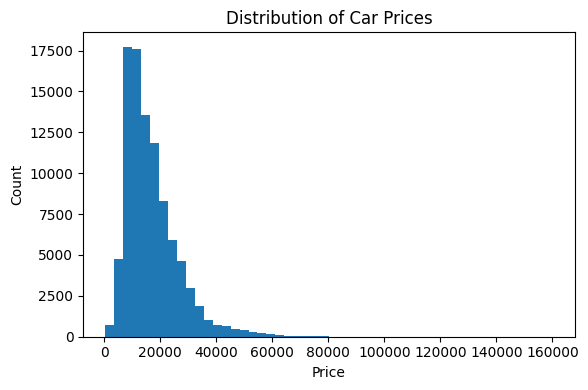

In [19]:
plt.figure(figsize=(6, 4))
plt.hist(full_df["price"], bins=50)
plt.xlabel("Price")
plt.ylabel("Count")
plt.title("Distribution of Car Prices")
plt.tight_layout()
plt.show()

### 1.3 Distributions of key numeric features

Next we inspect a few important numeric features:
- `year` (age of the car),
- `mileage`,
- `engineSize`.

We only need a rough sense of their ranges and shapes.

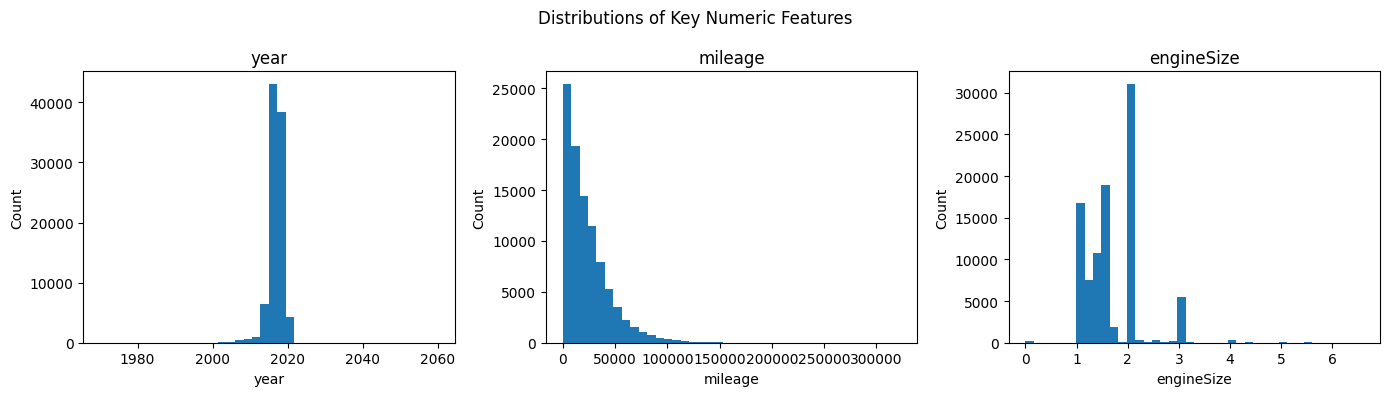

In [20]:
numeric_cols_for_plots = ["year", "mileage", "engineSize"]

fig, axes = plt.subplots(1, len(numeric_cols_for_plots), figsize=(14, 4))

for ax, col in zip(axes, numeric_cols_for_plots):
    ax.hist(full_df[col], bins=40)
    ax.set_title(col)
    ax.set_xlabel(col)
    ax.set_ylabel("Count")

plt.suptitle("Distributions of Key Numeric Features")
plt.tight_layout()
plt.show()

### 1.4 Price vs. numeric features

We now look at how the target (`price`) relates to a couple of numeric features:
- `mileage`
- `year`

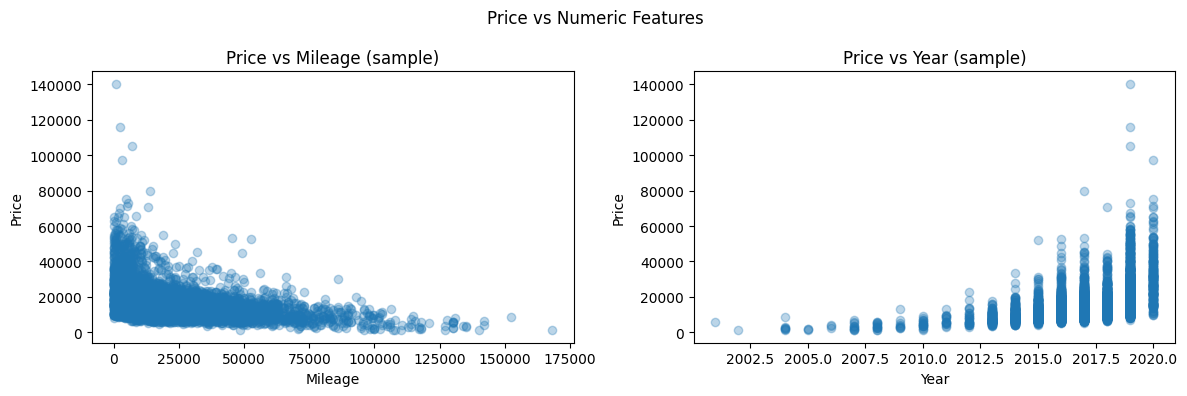

In [21]:
sample = full_df.sample(
    n=min(5000, len(full_df)),
    random_state=42
)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Price vs mileage
axes[0].scatter(sample["mileage"], sample["price"], alpha=0.3)
axes[0].set_xlabel("Mileage")
axes[0].set_ylabel("Price")
axes[0].set_title("Price vs Mileage (sample)")

# Price vs year
axes[1].scatter(sample["year"], sample["price"], alpha=0.3)
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Price")
axes[1].set_title("Price vs Year (sample)")

plt.suptitle("Price vs Numeric Features")
plt.tight_layout()
plt.show()

### 1.5 Price vs. categorical features

Finally, we check how price varies across a few categorical variables:
- `fuelType`
- `transmission`
- `car_brand`

This helps confirm that the categories seem sensible and that the
embeddings we learn later will have something meaningful to capture.

<Figure size 800x400 with 0 Axes>

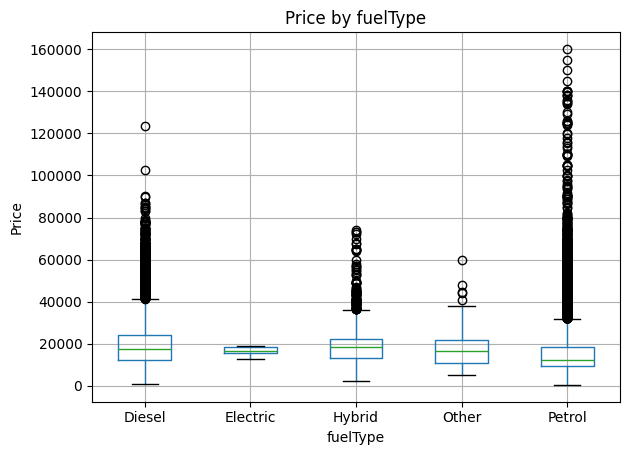

<Figure size 800x400 with 0 Axes>

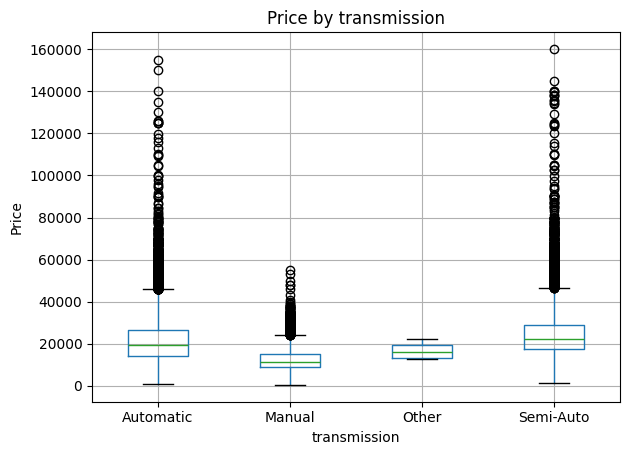

<Figure size 800x400 with 0 Axes>

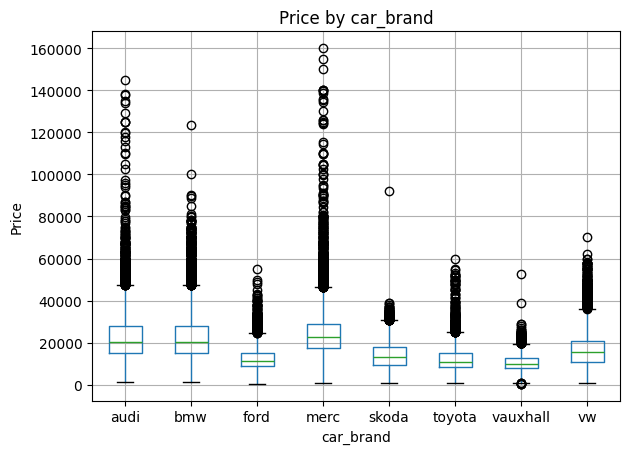

In [22]:
def boxplot_price_by_category(df, category_col, max_categories=10):
    """
    Draw a simple boxplot of price by a categorical column.

    For safety, we limit the number of categories shown to keep
    plots readable.
    """
    # If there are many categories, keep only the top ones by count
    value_counts = df[category_col].value_counts()
    top_categories = value_counts.index[:max_categories]
    filtered = df[df[category_col].isin(top_categories)]

    plt.figure(figsize=(8, 4))
    filtered.boxplot(column="price", by=category_col)
    plt.title(f"Price by {category_col}")
    plt.suptitle("")  # remove default pandas title
    plt.xlabel(category_col)
    plt.ylabel("Price")
    plt.tight_layout()
    plt.show()


boxplot_price_by_category(full_df, "fuelType")
boxplot_price_by_category(full_df, "transmission")
boxplot_price_by_category(full_df, "car_brand", max_categories=8)

### 1.6 Correlation with price

A quick numeric view of how strongly each numeric feature correlates

In [23]:
corr = full_df[["price", "year", "mileage", "tax", "mpg", "engineSize"]].corr()
corr["price"].sort_values(ascending=False)

price         1.000000
engineSize    0.637989
year          0.491989
tax           0.309715
mpg          -0.299290
mileage      -0.421421
Name: price, dtype: float64

## 2. Data Preparation and Feature Engineering

In this section we transform the cleaned dataset into the format expected by
our NumPy-based neural network.

Steps:

- Select which columns are treated as **categorical** vs **numeric**.
- **Label-encode** categorical features into integer indices (for embeddings).
- **Standardize** numeric features to zero mean and unit variance.
- **Standardize the target** (`price`) to help optimization.
- Split the data into **train**, **validation**, and **test** sets.

In [24]:
cat_cols = ["model", "transmission", "fuelType", "car_brand"]
num_cols = ["year", "mileage", "tax", "mpg", "engineSize"]

# --- Label encode categoricals ---
label_encoders = {}
for col in cat_cols:
    full_df[col] = full_df[col].astype(str).str.strip()
    le = LabelEncoder()
    full_df[col] = le.fit_transform(full_df[col])
    label_encoders[col] = le

# --- Scale numeric features ---
x_scaler = StandardScaler()
full_df[num_cols] = x_scaler.fit_transform(full_df[num_cols])

# --- Scale target (price) ---
y_scaler = StandardScaler()
y = full_df["price"].values.reshape(-1, 1)
y = y_scaler.fit_transform(y)

# --- Prepare arrays ---
X_cat = full_df[cat_cols].astype(int).values
X_num = full_df[num_cols].values
n_samples = len(full_df)

# 70% train, 15% val, 15% test
X_cat_train, X_cat_temp, X_num_train, X_num_temp, y_train, y_temp = train_test_split(
    X_cat, X_num, y, test_size=0.3, random_state=42
)

X_cat_val, X_cat_test, X_num_val, X_num_test, y_val, y_test = train_test_split(
    X_cat_temp, X_num_temp, y_temp, test_size=0.5, random_state=42
)

n_train = len(X_cat_train)
n_val = len(X_cat_val)
n_test = len(X_cat_test)

print("Train:", n_train, "Val:", n_val, "Test:", n_test)


n_model = int(full_df["model"].max()) + 1
n_brand = int(full_df["car_brand"].max()) + 1
n_trans = int(full_df["transmission"].max()) + 1
n_fuel  = int(full_df["fuelType"].max()) + 1

print("n_model:", n_model, "n_brand:", n_brand, "n_trans:", n_trans, "n_fuel:", n_fuel)

Train: 66028 Val: 14149 Test: 14150
n_model: 179 n_brand: 8 n_trans: 4 n_fuel: 5


## 3. Model Architecture and Embeddings

We now define the architecture of our neural network:

- For each categorical feature, we create an **embedding layer** with a chosen
  embedding dimension.
- We infer the total input dimensionality to the dense part of the network
  by:
  - passing a small batch through the embedding layers,
  - concatenating all embeddings with the numeric features.

This keeps the architecture flexible if we later change feature sets or
embedding sizes.

In [25]:
emb_model = Embedding(n_model, 16)
emb_brand = Embedding(n_brand, 8)
emb_trans = Embedding(n_trans, 4)
emb_fuel  = Embedding(n_fuel, 4)

# Infer dense input dim from TRAIN data
X_cat_sample = X_cat_train[:1]
X_num_sample = X_num_train[:1]

e1 = emb_model.forward(X_cat_sample[:, 0])
e2 = emb_brand.forward(X_cat_sample[:, 1])
e3 = emb_trans.forward(X_cat_sample[:, 2])
e4 = emb_fuel.forward(X_cat_sample[:, 3])

Xb_sample = np.concatenate([e1, e2, e3, e4, X_num_sample], axis=1)
dense_input_dim = Xb_sample.shape[1]
print("Dense input dim =", dense_input_dim)

Dense input dim = 37


### 3.1 Dense Network and Optimizer

With the embedding part defined, we construct the dense part of the network:

- A first dense layer with ReLU activation.
- A second dense layer with ReLU activation.
- A final dense layer with a single output neuron for the predicted price.

We use:

- **Mean Squared Error (MSE)** as the loss function.
- Theimplementation of the **Adam optimizer** to update all
  trainable parameters.

In [26]:
dense1 = Layer_Dense(dense_input_dim, 128)
relu1  = Activation_ReLU()
dense2 = Layer_Dense(128, 64)
relu2  = Activation_ReLU()
dense3 = Layer_Dense(64, 1)

loss_fn = Loss_MeanSquaredError()
optimizer = Optimizer_Adam(learning_rate=3e-4)

## 4. Training the Model

We now run the training loop.

For each epoch:

1. **Shuffle** the training data.
2. Iterate over **mini-batches**:
   - Forward pass through embeddings and dense layers.
   - Compute the MSE loss.
   - Backward pass to compute gradients for all layers (including embeddings).
   - Use Adam to update parameters.

After each epoch, we:

- Run a **validation forward pass** on the validation set.
- Inverse-transform the scaled predictions back to the original price scale.
- Compute and log evaluation metrics (MAE, MSE, MAPE) for monitoring.

In [28]:
epochs = 1000
batch_size = 128

history = []  # will store metrics per epoch

for epoch in range(epochs):

    perm = np.random.permutation(n_train)
    X_cat_train = X_cat_train[perm]
    X_num_train = X_num_train[perm]
    y_train = y_train[perm]

    epoch_loss = 0.0

    for i in range(0, n_train, batch_size):
        X_cat_b = X_cat_train[i:i+batch_size]
        X_num_b = X_num_train[i:i+batch_size]
        y_b = y_train[i:i+batch_size]

        # ---- FORWARD ----
        e1 = emb_model.forward(X_cat_b[:, 0])
        e2 = emb_brand.forward(X_cat_b[:, 1])
        e3 = emb_trans.forward(X_cat_b[:, 2])
        e4 = emb_fuel.forward(X_cat_b[:, 3])

        Xb = np.concatenate([e1, e2, e3, e4, X_num_b], axis=1)

        dense1.forward(Xb)
        relu1.forward(dense1.output)
        dense2.forward(relu1.output)
        relu2.forward(dense2.output)
        dense3.forward(relu2.output)

        predictions = dense3.output
        loss = loss_fn.forward(predictions, y_b)
        epoch_loss += loss

        # ---- BACKWARD ----
        loss_fn.backward(predictions, y_b)
        dense3.backward(loss_fn.dinputs)
        relu2.backward(dense3.dinputs)
        dense2.backward(relu2.dinputs)
        relu1.backward(dense2.dinputs)
        dense1.backward(relu1.dinputs)

        # Embedding grads (first 32 dims = 16+8+4+4)
        dcat = dense1.dinputs[:, :32]
        emb_model.backward(dcat[:, 0:16])
        emb_brand.backward(dcat[:, 16:24])
        emb_trans.backward(dcat[:, 24:28])
        emb_fuel.backward(dcat[:, 28:32])

        # ---- OPTIMIZER ----
        optimizer.update_params(dense1)
        optimizer.update_params(dense2)
        optimizer.update_params(dense3)
        optimizer.update_params(emb_model)
        optimizer.update_params(emb_brand)
        optimizer.update_params(emb_trans)
        optimizer.update_params(emb_fuel)

        optimizer.post_update_params()

    # ---- VALIDATION FORWARD ----
    e1_val = emb_model.forward(X_cat_val[:, 0])
    e2_val = emb_brand.forward(X_cat_val[:, 1])
    e3_val = emb_trans.forward(X_cat_val[:, 2])
    e4_val = emb_fuel.forward(X_cat_val[:, 3])

    Xb_val = np.concatenate([e1_val, e2_val, e3_val, e4_val, X_num_val], axis=1)

    dense1.forward(Xb_val)
    relu1.forward(dense1.output)
    dense2.forward(relu1.output)
    relu2.forward(dense2.output)
    dense3.forward(relu2.output)

    val_pred_scaled = dense3.output
    val_true = y_scaler.inverse_transform(y_val)
    val_pred = y_scaler.inverse_transform(val_pred_scaled)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {epoch_loss:.4f}")
    metrics = calculate_metrics(val_true, val_pred)  # returns dict

    # save in history
    history.append({
        "epoch": epoch + 1,
        "train_loss": epoch_loss,
        "val_mae": metrics["mae"],
        "val_mse": metrics["mse"],
        "val_mape": metrics["mape"],
    })

Epoch 1/1000 - Train Loss: 35.4561
Epoch 2/1000 - Train Loss: 33.7807
Epoch 3/1000 - Train Loss: 32.1864
Epoch 4/1000 - Train Loss: 31.0697
Epoch 5/1000 - Train Loss: 30.1379
Epoch 6/1000 - Train Loss: 29.3709
Epoch 7/1000 - Train Loss: 28.7074
Epoch 8/1000 - Train Loss: 28.0830
Epoch 9/1000 - Train Loss: 27.5408
Epoch 10/1000 - Train Loss: 27.3635
Epoch 11/1000 - Train Loss: 26.9162
Epoch 12/1000 - Train Loss: 26.5940
Epoch 13/1000 - Train Loss: 26.4090
Epoch 14/1000 - Train Loss: 26.0393
Epoch 15/1000 - Train Loss: 25.8414
Epoch 16/1000 - Train Loss: 25.6529
Epoch 17/1000 - Train Loss: 25.4774
Epoch 18/1000 - Train Loss: 25.1978
Epoch 19/1000 - Train Loss: 25.2059
Epoch 20/1000 - Train Loss: 25.2824
Epoch 21/1000 - Train Loss: 24.9091
Epoch 22/1000 - Train Loss: 24.7693
Epoch 23/1000 - Train Loss: 24.4476
Epoch 24/1000 - Train Loss: 24.4969
Epoch 25/1000 - Train Loss: 24.3433
Epoch 26/1000 - Train Loss: 24.3792
Epoch 27/1000 - Train Loss: 24.2505
Epoch 28/1000 - Train Loss: 23.9192
E

### 4.1 Training History

We convert the logged history into a DataFrame and visualize how the
training loss evolves over epochs. This gives a quick check that the
network is actually learning and that the learning rate is in a reasonable range.

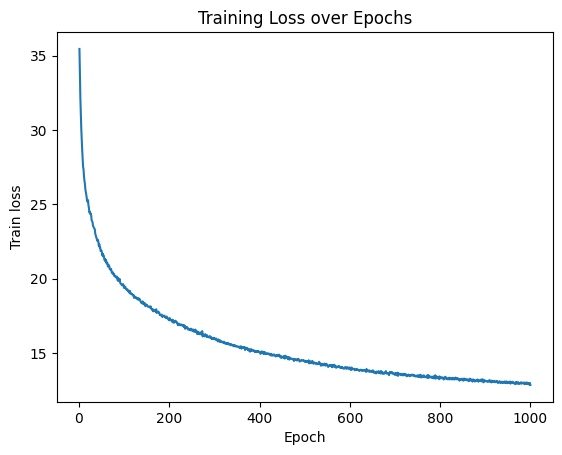

In [29]:
hist_df = pd.DataFrame(history)

plt.plot(hist_df["epoch"], hist_df["train_loss"])
plt.xlabel("Epoch")
plt.ylabel("Train loss")
plt.title("Training Loss over Epochs")
plt.show()

## 5. Final Evaluation on the Test Set

Finally, we evaluate the trained model on the held-out test set:

- Run a forward pass to obtain predictions.
- Inverse-transform predictions and targets back to the original price scale.
- Compute regression metrics (MAE, MAPE) on the test data.

This gives an unbiased estimate of how well the model generalizes to unseen cars.

In [30]:
e1_test = emb_model.forward(X_cat_test[:, 0])
e2_test = emb_brand.forward(X_cat_test[:, 1])
e3_test = emb_trans.forward(X_cat_test[:, 2])
e4_test = emb_fuel.forward(X_cat_test[:, 3])

Xb_test = np.concatenate([e1_test, e2_test, e3_test, e4_test, X_num_test], axis=1)

dense1.forward(Xb_test)
relu1.forward(dense1.output)
dense2.forward(relu1.output)
relu2.forward(dense2.output)
dense3.forward(relu2.output)

y_test_pred_scaled = dense3.output
y_test_true = y_scaler.inverse_transform(y_test)
y_test_pred = y_scaler.inverse_transform(y_test_pred_scaled)

print("\n=== FINAL TEST METRICS ===")
results = calculate_metrics(y_test_true, y_test_pred)
print(f"Mean absolute error (in pounds): {round(float(results.get('mae')),2)}")
print(f"Mean absolute percentage error {round(float(results.get('mape')),2)}%")


=== FINAL TEST METRICS ===
Mean absolute error (in pounds): 1160.06
Mean absolute percentage error 7.08%


## 6. Error Analysis and Visualisation

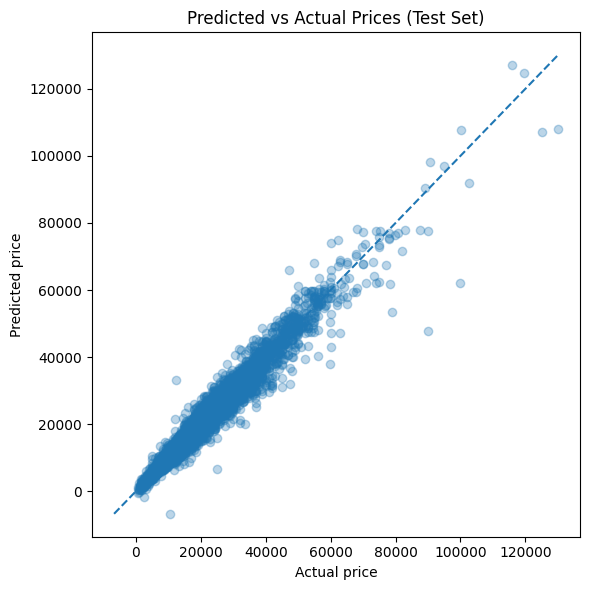

In [35]:
# Build a DataFrame for easier analysis
test_df = pd.DataFrame({
    "y_true": y_test_true.ravel(),
    "y_pred": y_test_pred.ravel(),
})

# Errors
test_df["error"] = test_df["y_pred"] - test_df["y_true"]
test_df["abs_error"] = test_df["error"].abs()

# Map encoded brand indices back to brand names
brand_codes = X_cat_test[:, 3].astype(int)  # car_brand is the 4th column in cat_cols
brand_names = label_encoders["car_brand"].inverse_transform(brand_codes)

test_df["brand_code"] = brand_codes
test_df["brand"] = brand_names

plt.figure(figsize=(6, 6))

plt.scatter(test_df["y_true"], test_df["y_pred"], alpha=0.3)
plt.xlabel("Actual price")
plt.ylabel("Predicted price")
plt.title("Predicted vs Actual Prices (Test Set)")

# Plot y = x line for reference
min_price = min(test_df["y_true"].min(), test_df["y_pred"].min())
max_price = max(test_df["y_true"].max(), test_df["y_pred"].max())
plt.plot([min_price, max_price], [min_price, max_price], linestyle="--")

plt.tight_layout()
plt.show()


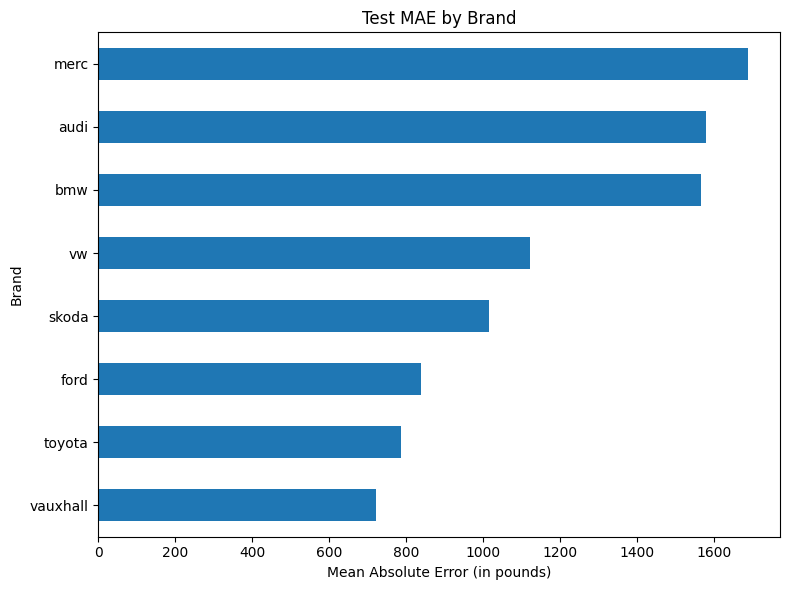

brand
vauxhall     721.783505
toyota       785.185002
ford         836.749505
skoda       1014.435933
vw          1120.996913
bmw         1565.837873
audi        1578.613998
merc        1685.950235
Name: abs_error, dtype: float64

In [36]:
# Compute MAE per brand
brand_mae = (
    test_df.groupby("brand")["abs_error"]
    .mean()
    .sort_values(ascending=True)
)

plt.figure(figsize=(8, 6))

brand_mae.plot(kind="barh")
plt.xlabel("Mean Absolute Error (in pounds)")
plt.ylabel("Brand")
plt.title("Test MAE by Brand")

plt.tight_layout()
plt.show()

brand_mae
